### This notebook works with dog-project conda env that is installed with 

https://github.com/parksoy/Soyoung_Udacity_ND_DeepLearning/blob/master/3.Convolutional_networks/7_dog-project/requirements/dog-linux-gpu.yml

in AWS, deep learning AMI with source code, ubuntu, CUDA8. N. Virginia server was chosen.

In [1]:
# Check for a GPU
import tensorflow as tf
print(tf.test.gpu_device_name())

/gpu:0


In [2]:
%%bash
pwd

/home/ubuntu/Soyoung_Udacity_ND_DeepLearning/5.Generative_Adversarial_Networks/3_face_generation


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = 'data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

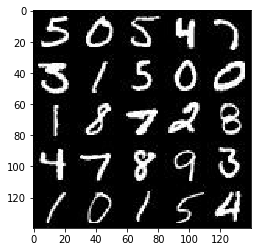

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

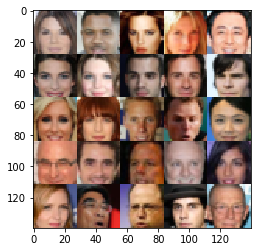

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32, name='learning_rate')  

    return  inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

### reviewer#1 

#### Discriminator  
1) Leaky ReLU activation function helps with the gradient flow and alleviate the problem of sparse gradients (almost 0 gradients). Max pooling generates sparse gradients, which affects the stability of GAN training. That’s the reason, you chose not to use pooling.

2) You have used batch normalization to stabilize GAN training by reducing internal covariant shift. You can go to this link[http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html] for further understanding Batch norm.

3) You have used Sigmoid as the activation function for the output layer which produces probability-like values between 0 and 1.

Improvement to make:
<font color='red'>
1) Use custom weight initialization. For example Xavier weight initialization to help converge faster by breaking symmetry or you can also use truncated_normal_initializer with stddev=0.02, which improve overall generated image quality, like in DCGAN paper.  

2) Experiment with various values of alpha (slope of the leaky Relu as stated in DCGAN paper) between 0.06 and 0.18 and compare your results.  
 
3) Experiment with dropout layers for discriminator, applying dropout will decrease hyper learning distrib. If discriminator end up dominating generator, we must reduce discriminator learning rate and increase dropout.   
</font>  


Ref: F. Chollet, "Deep Learning with Python" chapt 8.32".   

Use: 

```
dp_layer = tf.nn.dropout(l_relu_output, keep_prob =0.8) or 
dp_layer = tf.layer.dropout(l_relu_output, rate =0.2)
```

In [38]:
#https://discussions.udacity.com/t/discriminator-variable-scope-reuse/662468

depth = 64 #==filters=the dimensionality of the output space(i.e. the number of filters in the convolution).
kernel_size=5 # kernel_size=height and width of the 2D convolution window
strides=2
alpha=0.06 #if this is not within this variable_scope, can not pass test: assert mock_variable_scope.call_args == mock.call('discriminator', reuse=True)
#tf.variable_scope called with wrong arguments in Discriminator Inference(reuse=True)
#Reviewer#1: Experiment with various values of alpha (slope of the leaky Relu as stated in DCGAN paper) between 0.06 and 0.18 and compare your results.
        
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse) :
        
       
        # Hidden layer #1: Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, filters=depth, kernel_size = kernel_size, strides=strides, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * h1, h1)
        relu1_dropout = tf.nn.dropout(relu1, keep_prob =0.8)
        # 14x14x64 now
        
        # Hidden layer #2: 
        h2 = tf.layers.conv2d(relu1_dropout, filters=depth*2, kernel_size = kernel_size, strides=strides, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2_dropout = tf.nn.dropout(relu2, keep_prob =0.8)
        # 7x7x128 now
        
        # Hidden layer #3: 
        h3 = tf.layers.conv2d(relu2, filters=depth*4, kernel_size = kernel_size, strides=strides, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3_dropout = tf.nn.dropout(relu3, keep_prob =0.8)
        # 3x3x256 now

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*depth*4))
        logits = tf.layers.dense(flat, 1)
        isFakeReal = tf.nn.sigmoid(logits)
        
        return isFakeReal, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

### Reviewer#1

#### Generator  

You have used Tanh as the last layer of the generator output, so you will normalize the input images to be between -1 and 1 in train function.

You have met the basic requirements, but I recommend you to work on the below tips and comment on the improvements you see in the generated image.

<font color='red'>  
    
1) Experiment with more conv2d_transpose layers in generator block so that there're enough parameters in the network to learn the concepts of the input images. **DCGAN models produce better results when generator is bigger than discriminator.**  

Suggestion: 1024->512->256->128->out_channel_dim (Use stride as 1 to increase the number of layers without changing the size of the output image).   

2) Experiment with different slope values for leaky_relu as told in discriminator.  

3) Experiment dropout in generator, so that it is less prone to learning the data distribution and avoid generating images that look like noise.   

(CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC)  
</font>

In [48]:
strides = 1
depth = 128

In [39]:
def generator(z, out_channel_dim,  is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        #Using the reverse process of the discriminator
        #alpha=0.2
        
        # Hidden layer #1: starts with 1024
        h1 = tf.layers.dense(z, 2*2*depth*2) # First fully connected layer, 1024
        h1 = tf.reshape(h1, (-1, 2, 2, depth*2)) ## Reshape it to start the convolutional stack 2x2x512
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h1_dropout = tf.nn.dropout(h1, keep_prob =0.8)
        #2x2x512 now
        
        # Hidden layer #2:
        h2 = tf.layers.conv2d_transpose(h1_dropout, depth*2, kernel_size = kernel_size, strides=strides, padding='valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2_dropout = tf.nn.dropout(h2, keep_prob =0.8)
        #7x7x256 now
        
        # Hidden layer #3:
        h3 = tf.layers.conv2d_transpose(h2_dropout, depth, kernel_size = kernel_size, strides=strides, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3_dropout = tf.nn.dropout(h3, keep_prob =0.8)
        #14x14x128 now
        
        # Hidden layer #4:
        h4 = tf.layers.conv2d_transpose(h3_dropout, depth, kernel_size = kernel_size, strides=strides, padding='same')
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(alpha * h4, h4)
        h4_dropout = tf.nn.dropout(h4, keep_prob =0.8)
        #14x14x32 now
    
        logits = tf.layers.conv2d_transpose(h4_dropout, out_channel_dim, kernel_size = kernel_size, strides=strides, padding='same')
        fake_image = tf.tanh(logits)
        #28x28x3 or 28x28x1 now
    
        return fake_image


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Reviewer #1

<font color='red'>    
Experiment with label smoothing for discriminator loss, it prevents discriminator from being too strong and to   generalize in a better way.    
</font>
Refer https://arxiv.org/abs/1606.03498

Below is a starter code,   
 
```python
d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
```

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Initializing Variables with predictions
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

### Reviewer #1 

<font color='red'>    
To avoid internal covariant shift during training, you use batch norm. But in tensorflow **when is_train is true and you have used batch norm, mean and variance needs to be updated before optimization**. So, you add control dependency on the update ops before optimizing the network.   
</font>  

    More Info here 

http://ruishu.io/2016/12/27/batchnorm/

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Empty TF TrainableVariables
    t_vars = tf.trainable_variables()
    # Append var to D & G vars arraies if it starts with the "prefix" for on it name
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # discriminator optimization
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    # UPDATE OPS GraphKeys
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

### Reviewer #1

Great work combining all the functions together and making it a DCGAN.

Good job scaling the input images to the same scale as the generated ones using batch_images *= 2.0 .

Tip:   
  
**Execute the optimization for generator twice. This ensures that the discriminator loss does not go to 0 and impede learning.**  

Extra:  
1) Talk on “How to train a GAN” by one of the author of original DCGAN paper here..https://www.youtube.com/watch?v=X1mUN6dD8uE

2) Here is a post on Gan hacks, https://github.com/soumith/ganhacks  

<font color='red'>
3) Plot discriminator and generator loss for better understanding. You can utilize the below code snippet to plot the loss graph to get a better understanding.
</font>

```
d,_ = sess.run(…)
g,_ = sess.run(…)
d_loss_vec.append(d)
g_loss_vec.append(g)
```

At the end, you can include the below code to plot the final array:

```
Discriminator_loss, = plt.plot(d_loss_vec, color='b', label='Discriminator loss')
Genereator_loss, = plt.plot(g_loss_vec, color='r', label='Generator loss')
plt.legend(handles=[ Discriminator_loss, Genereator_loss])
```


In [43]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape # 28x28x3 or 28x28x1
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    n_images = 25        
    print_every = 20
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1 
                batch_images *= 2.0 
                
                # Sample random "noise vector" for generator
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) 
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # Showing the generator image output for every = show_every step
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

### Reviewer #1

The hyperparameters chosen are correct. You can further improve the quality of the generated image by experimenting with the parameters and the tips I provided in discriminator, generator and model loss. Below are a few extra tips on choosing the hyperparameters for starters...

Tips: 
1) Try using different values of learning rate between 0.0002 and 0.0008, this DCGAN architectural structure remains stable within that range.

2) Experiment with different values of beta1 between 0.2 and 0.5 and compare your results. Here's a good post explaining the importance of beta values and which value might be empirically better. http://ruder.io/optimizing-gradient-descent/index.html#adam.

3) An important point to note is, batch size and learning rate are linked. If the batch size is too small then the gradients will become more unstable and would need to reduce the learning rate and vice versa. Start point for experimenting on batch size would be somewhere between 16 to 32.

Extra: You can also go through Population based training of neural networks, https://deepmind.com/blog/population-based-training-neural-networks/ it is a new method for training neural networks which allows an experimenter to quickly choose the best set of hyperparameters and model for the task.



Epoch 1/2... Discriminator Loss: 0.4586... Generator Loss: 10.7796
Epoch 1/2... Discriminator Loss: 0.1117... Generator Loss: 3.2811
Epoch 1/2... Discriminator Loss: 0.3267... Generator Loss: 2.5419
Epoch 1/2... Discriminator Loss: 0.0743... Generator Loss: 3.0553
Epoch 1/2... Discriminator Loss: 0.0435... Generator Loss: 4.9247


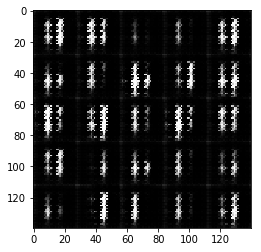

Epoch 1/2... Discriminator Loss: 0.0540... Generator Loss: 4.3030
Epoch 1/2... Discriminator Loss: 0.1569... Generator Loss: 2.6781
Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 0.0272... Generator Loss: 4.6509
Epoch 1/2... Discriminator Loss: 0.0225... Generator Loss: 7.8181


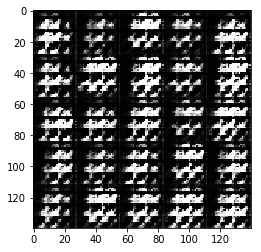

Epoch 1/2... Discriminator Loss: 0.1239... Generator Loss: 4.0174
Epoch 1/2... Discriminator Loss: 0.0458... Generator Loss: 4.0952
Epoch 1/2... Discriminator Loss: 0.1269... Generator Loss: 6.4397
Epoch 1/2... Discriminator Loss: 0.3173... Generator Loss: 3.3973
Epoch 1/2... Discriminator Loss: 0.2768... Generator Loss: 3.3770


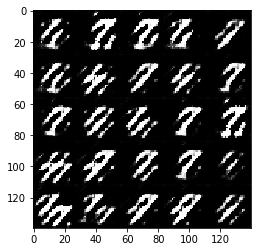

Epoch 1/2... Discriminator Loss: 0.2495... Generator Loss: 2.4156
Epoch 1/2... Discriminator Loss: 0.2320... Generator Loss: 6.1080
Epoch 1/2... Discriminator Loss: 0.1094... Generator Loss: 7.2459
Epoch 1/2... Discriminator Loss: 0.6528... Generator Loss: 10.1956
Epoch 1/2... Discriminator Loss: 0.2000... Generator Loss: 4.2067


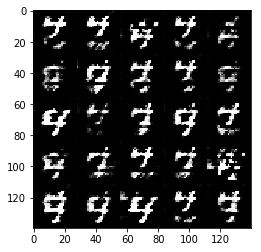

Epoch 1/2... Discriminator Loss: 0.2138... Generator Loss: 3.1202
Epoch 1/2... Discriminator Loss: 0.3346... Generator Loss: 2.6087
Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 1.9895
Epoch 1/2... Discriminator Loss: 0.1972... Generator Loss: 5.3439
Epoch 1/2... Discriminator Loss: 0.4054... Generator Loss: 7.9492


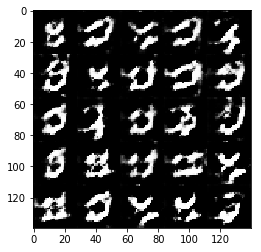

Epoch 1/2... Discriminator Loss: 0.5238... Generator Loss: 2.2534
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 0.2909... Generator Loss: 2.5921
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 3.1037
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.4213


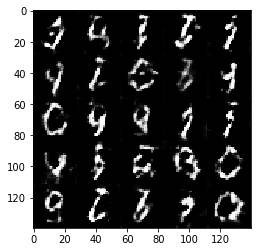

Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 1.9665
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 4.2772
Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 1.5791
Epoch 1/2... Discriminator Loss: 1.6890... Generator Loss: 0.2975


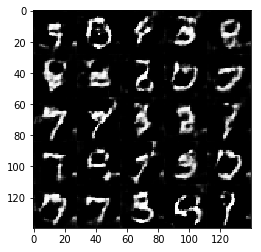

Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 0.8740
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 1.0385
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.4159
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 1.5989


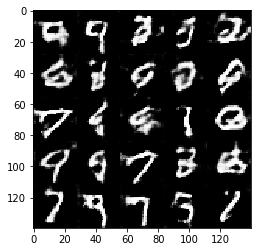

Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 1.5480
Epoch 1/2... Discriminator Loss: 0.4025... Generator Loss: 1.8863
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 2.0791
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.4778


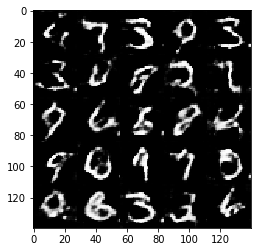

Epoch 1/2... Discriminator Loss: 2.0128... Generator Loss: 0.3032
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 2.8342
Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 1.1748
Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 1.5188
Epoch 1/2... Discriminator Loss: 1.8877... Generator Loss: 0.2942


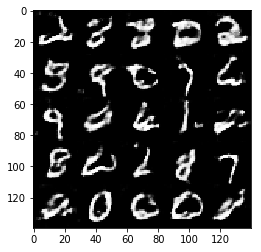

Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.5224
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 0.4985... Generator Loss: 2.5131


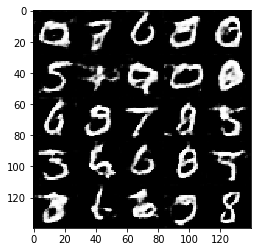

Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 1.3026
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.5993
Epoch 1/2... Discriminator Loss: 2.0601... Generator Loss: 0.2130
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.8946
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 0.7164


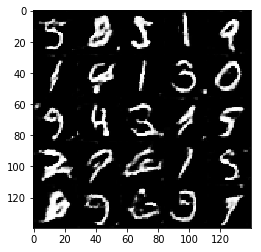

Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 1.8975
Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 1.3526
Epoch 1/2... Discriminator Loss: 0.8638... Generator Loss: 1.0683
Epoch 1/2... Discriminator Loss: 0.7512... Generator Loss: 2.5588
Epoch 1/2... Discriminator Loss: 1.6967... Generator Loss: 0.3791


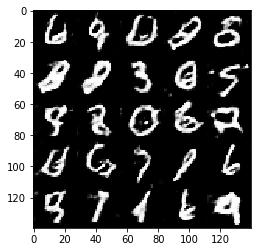

Epoch 1/2... Discriminator Loss: 0.7437... Generator Loss: 1.0930
Epoch 1/2... Discriminator Loss: 0.7731... Generator Loss: 1.4970
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 2.1105... Generator Loss: 0.2180
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 0.8500


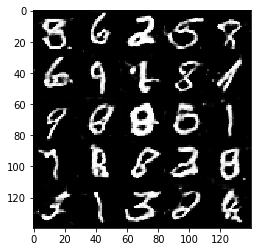

Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 1.0286
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.7414
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 0.9030


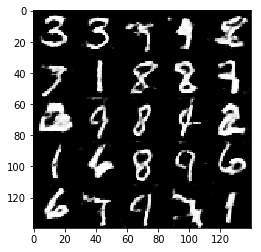

Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.3995
Epoch 1/2... Discriminator Loss: 0.6938... Generator Loss: 1.7406
Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.6272
Epoch 1/2... Discriminator Loss: 1.6132... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.2055


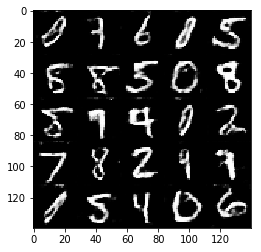

Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 0.8463... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.8601
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 0.8264


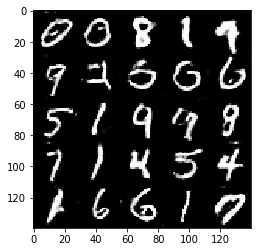

Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 1.1116
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.8300... Generator Loss: 0.3958
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.5341


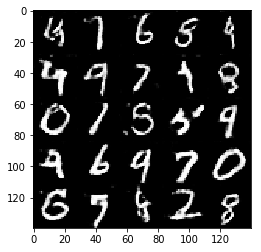

Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 1.1256
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.2062
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.2444
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 2.6536


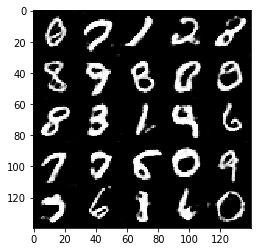

Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.4873
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.3178


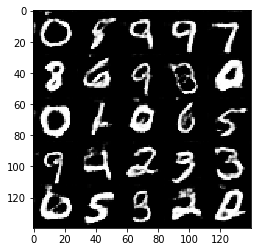

Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 0.9827
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 2.0551
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.4568
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.6430


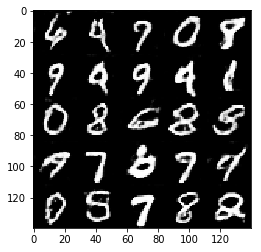

Epoch 2/2... Discriminator Loss: 0.8406... Generator Loss: 1.5035
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 1.6168
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 2.7558
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 0.7744


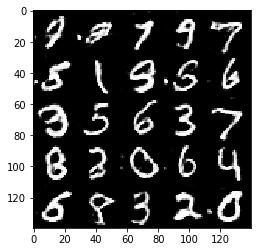

Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 1.3509
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.7665


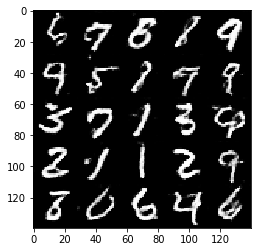

Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 0.8952


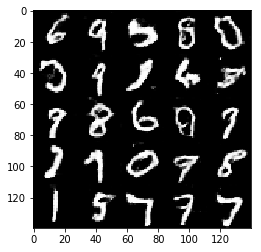

Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 1.8430
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 0.3091
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.8106
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.5069
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 0.9508


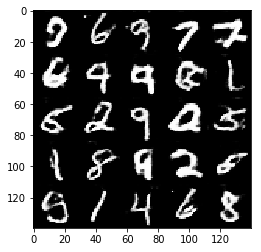

Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.1106
Epoch 2/2... Discriminator Loss: 2.1495... Generator Loss: 0.2372
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 0.6928... Generator Loss: 1.7556


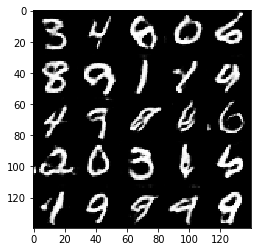

Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 1.2920
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.4252
Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.1978


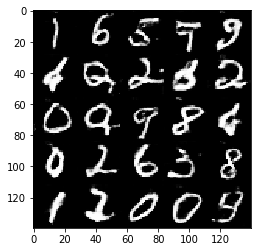

Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 1.7109
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.5296
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 0.8128


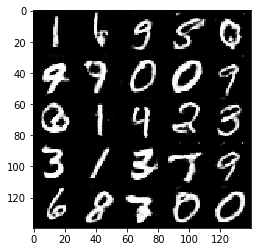

Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 0.6277... Generator Loss: 1.3797
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 2.3151
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.4505


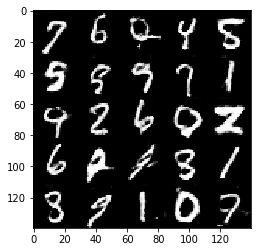

Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 1.3442
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 0.9367
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 1.8405


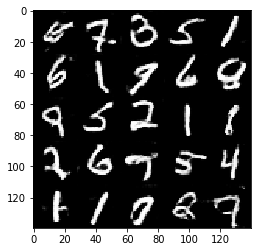

Epoch 2/2... Discriminator Loss: 0.5399... Generator Loss: 1.8652
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 1.4579
Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 2.6595
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 0.7271


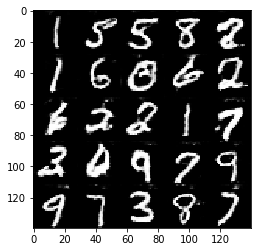

Epoch 2/2... Discriminator Loss: 2.2728... Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 2.7369
Epoch 2/2... Discriminator Loss: 0.4903... Generator Loss: 1.7072
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 2.1082
Epoch 2/2... Discriminator Loss: 2.0125... Generator Loss: 0.2985


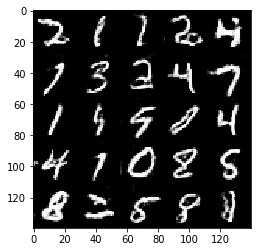

Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 0.9795
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.5288... Generator Loss: 3.5669
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 2.7145
Epoch 2/2... Discriminator Loss: 1.6769... Generator Loss: 0.3848


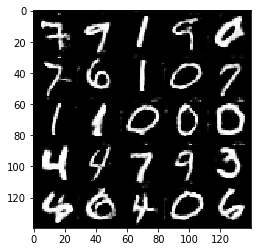

Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 1.4169


In [44]:
batch_size = 36 # Reviewer#1 Start point for experimenting on batch size would be somewhere between 16 to 32.
z_dim = 100
learning_rate = 0.002
beta1 = 0.5 # AdamOptimizer. Reviewer#1: Experiment with different values of beta1 between 0.2 and 0.5 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [45]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
mnist_dataset.shape

(60000, 28, 28, 1)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

### Reviewer #1

<font color='red'>  
If you want to generate varied face shapes, experiment with the value of z_dim (probably in the range 128 - 256).  
</font>  

Epoch 1/1... Discriminator Loss: 0.2675... Generator Loss: 2.4303
Epoch 1/1... Discriminator Loss: 1.7862... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.2839... Generator Loss: 2.4946
Epoch 1/1... Discriminator Loss: 3.1914... Generator Loss: 7.7279


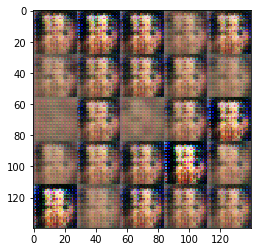

Epoch 1/1... Discriminator Loss: 0.4303... Generator Loss: 1.7805
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 3.7292
Epoch 1/1... Discriminator Loss: 0.1635... Generator Loss: 2.4136
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 1.9196
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 2.2059


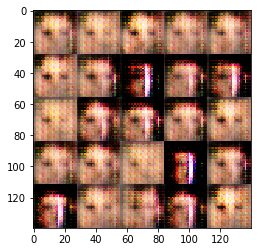

Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 4.1350
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 2.0602
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 2.2727... Generator Loss: 0.4534


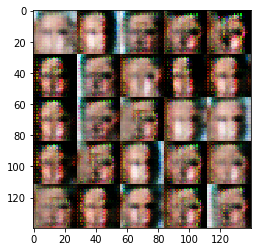

Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.4899
Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.2769


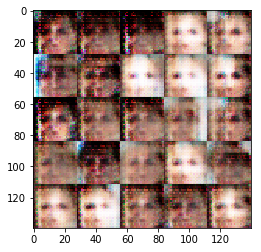

Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.5850
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 2.4013
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.3986
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.1056


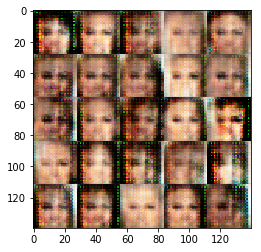

Epoch 1/1... Discriminator Loss: 1.8752... Generator Loss: 0.2899
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.6924
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 2.4863
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.2539


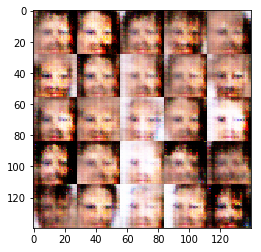

Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 3.2545
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.6969


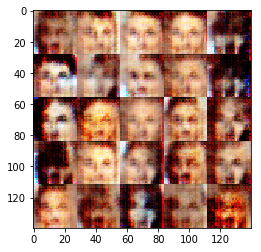

Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 2.1349... Generator Loss: 3.4944
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 2.8966
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 0.9707


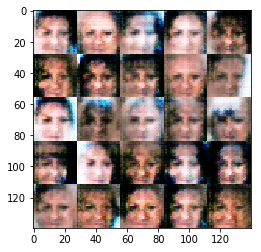

Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.6685
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.4409


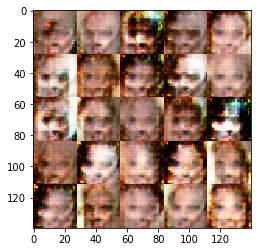

Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 2.6756
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 2.5217
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.6114
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 2.6178


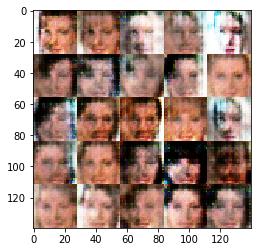

Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 1.9616
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.0205


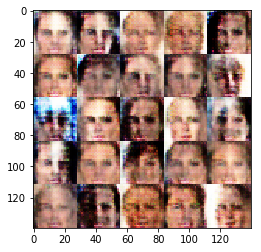

Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.7696


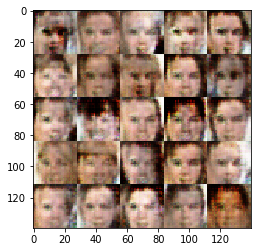

Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.9440
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 2.2359


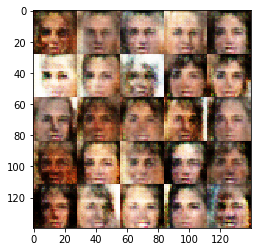

Epoch 1/1... Discriminator Loss: 1.7110... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.9635... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.8704


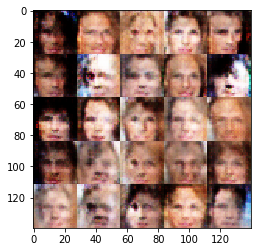

Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 3.5037
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8284


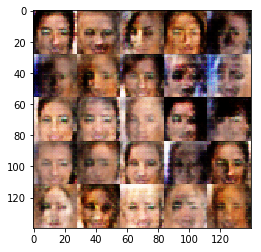

Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 0.6546... Generator Loss: 1.5333
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.8451
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.0594


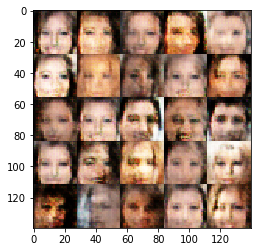

Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.7453


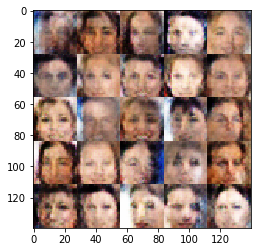

Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.5680
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.2993
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.6645
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.1882


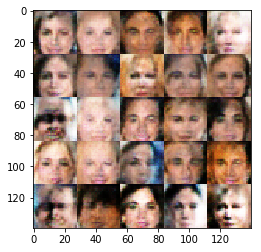

Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 2.0435
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.0518


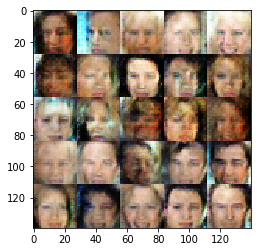

Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.6377
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.0311


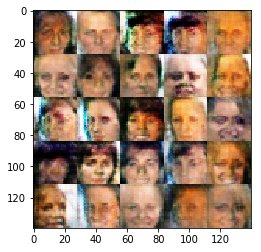

Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 3.2370
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.1823


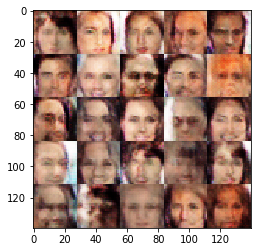

Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 2.6614
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.6253


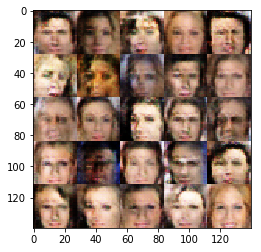

Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.5383


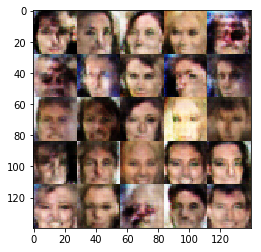

Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.6503


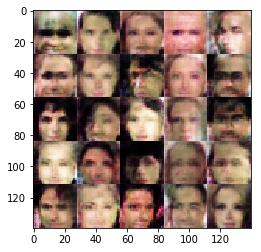

Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 1.4114
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.8773
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0980


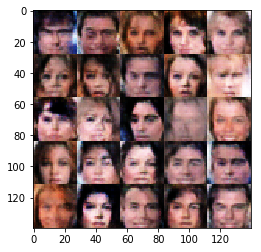

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.9407
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6042


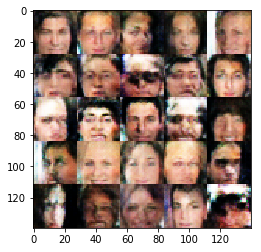

Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 0.8739


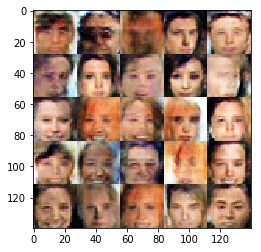

Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7737


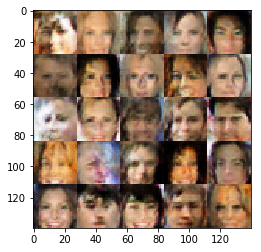

Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 0.9553


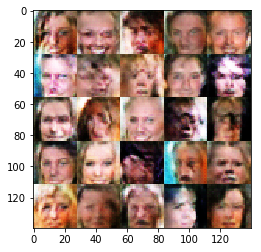

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 2.2716
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.4896


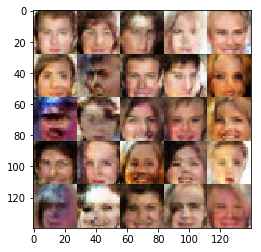

Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.6198


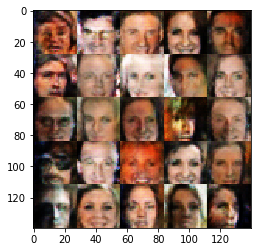

Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.6952


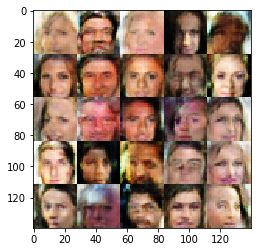

Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.6918
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.6132


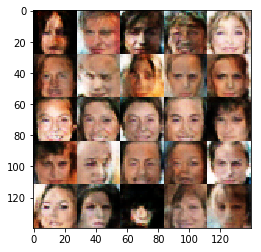

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.9141


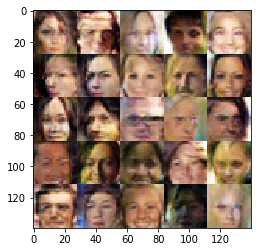

Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.6350
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.5282


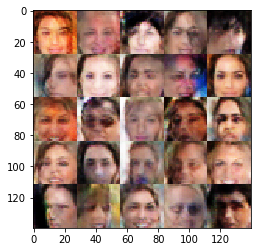

Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.8063


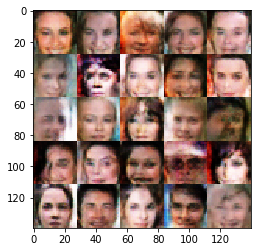

Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.2354


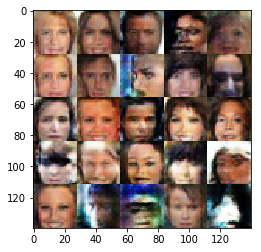

Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.6471


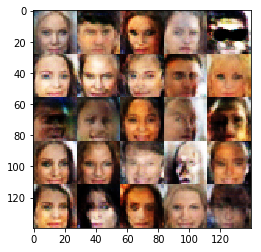

Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.8663


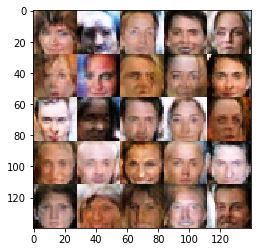

Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.6279


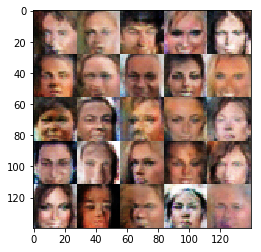

Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.2245


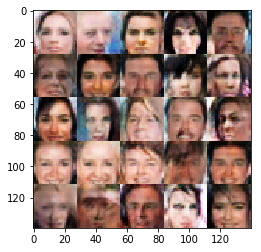

Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 0.8916


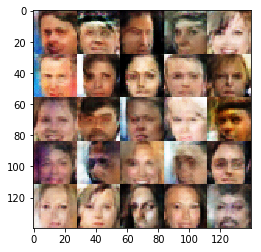

Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.7284
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.6273


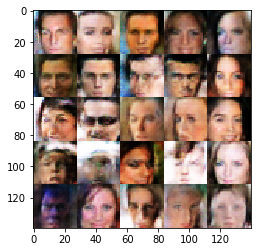

Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.8177


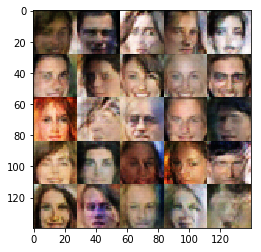

Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.5590


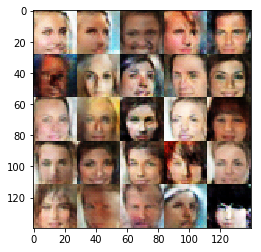

Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.2009


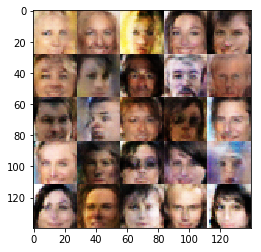

Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8239


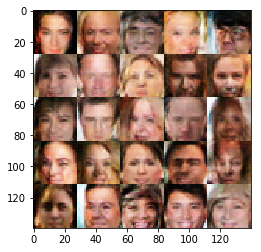

Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.6134


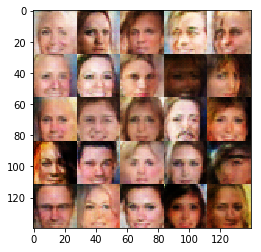

Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.7268


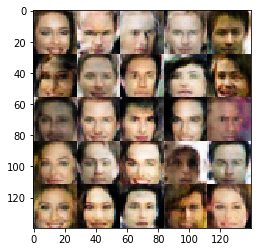

Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.6522
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.7198
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7498


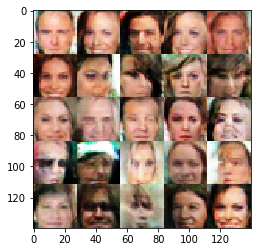

Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9377


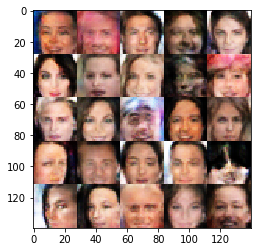

Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.8080


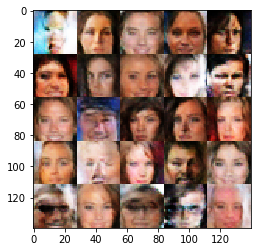

Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.8656


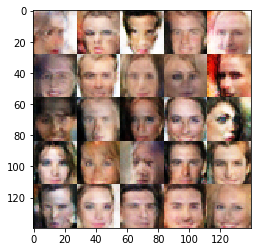

Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.5296


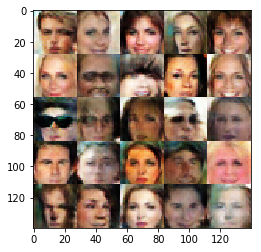

Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.2274


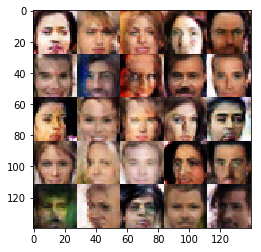

Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.8917


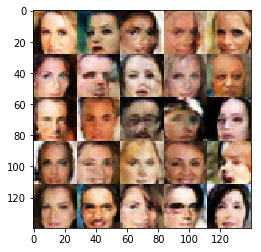

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.6584


In [46]:
batch_size = batch_size
z_dim = z_dim
learning_rate = learning_rate
beta1 = beta1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [47]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
celeba_dataset.shape

(202599, 28, 28, 3)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.